In [1]:
dataset = "merfish"
figdir = "/home/ckmah/projects/bento-manuscript/figures"

# Setup

In [2]:
import bento as bt
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import sparse
# from hmr import Reloader
from statannotations.Annotator import Annotator

# bento = Reloader(bento)
bt.settings.verbosity = 'INFO'

# Quality Control

In [3]:
adata = bt.ds.load_dataset(dataset)

Remove cells without nuclei

In [4]:
adata = adata[adata.obs["nucleus_shape"] != None]

Check QC distributions

In [5]:
bt.tl.obs_stats(adata)


  0%|          | 0/3 [00:00<?, ?it/s]

[11:17:13] INFO     AnnData object modified:                                                        ]8;id=569914;file:///projects/ps-yeolab4/spatial_project/bento-tools/bento/_settings.py\_settings.py]8;;\:]8;id=759563;file:///projects/ps-yeolab4/spatial_project/bento-tools/bento/_settings.py#48\48]8;;\
                        obs:                                                                                       
                            + cell_aspect_ratio, cell_area, cell_density                                           

  0%|          | 0/3 [00:00<?, ?it/s]

[11:17:20] INFO     AnnData object modified:                                                        ]8;id=221969;file:///projects/ps-yeolab4/spatial_project/bento-tools/bento/_settings.py\_settings.py]8;;\:]8;id=496696;file:///projects/ps-yeolab4/spatial_project/bento-tools/bento/_settings.py#48\48]8;;\
                        obs:                                                                                       
                            + nucleus_area, nucleus_aspect_ratio, nucleus_density                                  

Saved to /home/ckmah/projects/bento-manuscript/figures/merfish_obs_stats.svg


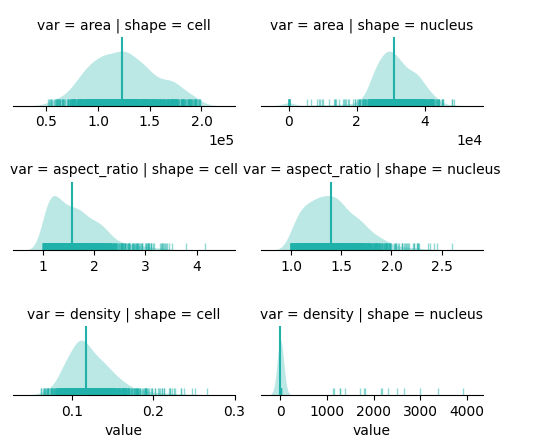

In [6]:
bt.pl.obs_stats(
    adata, rug=True, fname=f"{figdir}/merfish_obs_stats.svg"
)

## Filter out poor quality cells.
- remove cells with extremely small nuclei

Perform filtering

In [7]:
adata = adata[adata.obs["nucleus_area"] >= 10000]

In [8]:
adata.shape

(1000, 135)

In [9]:
bt.pl.obs_stats(adata)

# Compare clq distributions

In [10]:
adata.obs["cytoplasm_shape"] = bt.geo.get_shape(
    adata, "cell_shape"
) - bt.geo.get_shape(adata, "nucleus_shape")

adata.uns["points"]["cytoplasm"] = adata.uns["points"]["nucleus"] != -1

In [11]:
shapes = ["nucleus_shape", "cytoplasm_shape"]
bt.tl.coloc_quotient(
    adata, shapes=shapes, radius=20, min_points=10, min_cells=0
)

nucleus_shape:   0%|          | 0/1000 [00:00<?, ?it/s]

cytoplasm_shape:   0%|          | 0/1000 [00:00<?, ?it/s]

[11:21:59] INFO     AnnData object modified:                                                        ]8;id=868363;file:///projects/ps-yeolab4/spatial_project/bento-tools/bento/_settings.py\_settings.py]8;;\:]8;id=602568;file:///projects/ps-yeolab4/spatial_project/bento-tools/bento/_settings.py#48\48]8;;\
                        uns:                                                                                       
                            + clq                                                                                  

In [12]:
clq_long = []
for shape, clq in adata.uns["clq"].items():
    clq["compartment"] = shape.split("_")[0]
    clq_long.append(clq)

clq_long = pd.concat(clq_long, axis=0)
clq_long["self"] = clq_long["gene"] == clq_long["neighbor"]
clq_long["self"] = clq_long["self"].map({True: "self", False: "pair"})
# clq_long["log(clq + 1)"] = np.log2(clq_long["clq"] + 1)
clq_long = clq_long.query("clq > 0").sort_values("log_clq")

In [13]:
sns.clustermap(
    clq_long.groupby(["compartment", "gene", "neighbor"])
    .agg("mean")
    .reset_index()
    .query('compartment == "nucleus"')
    .pivot(index="gene", columns="neighbor", values="log_clq")
    .fillna(0),
    cmap="RdBu_r",
    center=0,
    z_score=1,
)

In [14]:
clq_long.groupby(["compartment", "self"]).size()

compartment  self
cytoplasm    pair    12254430
             self      115187
nucleus      pair     6778402
             self       86474
dtype: int64

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(5, 3))
sns.violinplot(
    data=clq_long,
    y="self",
    x="log_clq",
    hue="compartment",
    split=True,
    inner="quartiles",
    cut=0,
    palette=sns.color_palette(["#DDD", "#AAA"]),
    ax=ax,
)

# n_samples = clq_long.groupby(["compartment", "self"]).size()

# xticklabels = []
# for compartment, row in zip(
#     clq_long["compartment"].unique(), n_samples.values.reshape(2, 2)
# ):
#     cat_ns = ", ".join([str(v) for v in row])
#     xticklabels.append("n = " + cat_ns + f"\n{compartment}")

# ax.set_xticklabels(xticklabels)
ax.set_ylabel(None)
ax.legend()
sns.despine()

# Pairwise tests of significance (with correction)
pairs = [
    (("pair", "cytoplasm"), ("self", "cytoplasm")),
    (("pair", "nucleus"), ("self", "nucleus")),
    (("pair", "cytoplasm"), ("pair", "nucleus")),
    (("self", "cytoplasm"), ("self", "nucleus")),
]

annotator = Annotator(
    ax,
    pairs,
    data=clq_long,
    y="self",
    x="log_clq",
    hue="compartment",
    orient="h",
)
annotator.configure(
    test="Mann-Whitney",
    comparisons_correction="Benjamini-Hochberg",
    text_format="star",
    loc="outside",
)
annotator.apply_and_annotate()

fname = f"{figdir}/{dataset}_clq_dists.svg"
rc = {"svg.fonttype": "none", "font.family": "Arial"}
with plt.rc_context(rc):
    plt.savefig(fname, dpi=400)

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

self_cytoplasm vs. self_nucleus: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=6.086e+09
pair_cytoplasm vs. pair_nucleus: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=4.224e+13
pair_cytoplasm vs. self_cytoplasm: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=1.876e+11
pair_nucleus vs. self_nucleus: Mann-Whitney-Wilcoxon test two-sided with Benjamini-Hochberg correction, P_val:0.000e+00 U_stat=8.757e+10


In [16]:
clq_long.query('gene == "MALAT1" & neighbor == "CNR2"').groupby("compartment").mean()

,clq,log_clq
compartment,,
cytoplasm,163.395849,7.064930
nucleus,166.780195,7.218959


# Tensor decomposition

In [17]:

ranks = range(2, 11)
# ranks = [4]
bt.tl.colocation(adata, ranks, iterations=3)

Preparing tensor...
(2, 1000, 18225)
:running: Decomposing tensor...


Device cpu:   0%|          | 0/9 [00:00<?, ?it/s]

:heavy_check_mark: Done.


[12:11:14] INFO     AnnData object modified:                                                        ]8;id=996600;file:///projects/ps-yeolab4/spatial_project/bento-tools/bento/_settings.py\_settings.py]8;;\:]8;id=732713;file:///projects/ps-yeolab4/spatial_project/bento-tools/bento/_settings.py#48\48]8;;\
                        uns:                                                                                       
                            + tensor_names, tensor_labels, factors, tensor, factors_error                          

In [18]:

rank = 4

hm_params = dict(
    show_labels=[True, False, True],
    z_score=[False, True, True],
    cluster=[False, True, False],
)

# without self pairs
bt.pl.colocation(
    adata,
    rank,
    n_top=[None, None, 5],
    cut=[None, 5, None],
    self_pairs=False,
    **hm_params,
    fname=f"{figdir}/{dataset}_coloc{rank}.svg",
)

# only self pairs
bt.pl.colocation(
    adata,
    rank,
    n_top=[None, None, 5],
    cut=[None, 5, None],
    self_pairs="only",
    **hm_params,
    fname=f"{figdir}/{dataset}_coloc{rank}_self.svg",
)

Saved to /home/ckmah/projects/bento-manuscript/figures/merfish_coloc4.svg
Saved to /home/ckmah/projects/bento-manuscript/figures/merfish_coloc4_self.svg


# Cell associations

In [19]:
cell_factor = pd.DataFrame(
    adata.uns["factors"][rank][1], index=adata.uns["tensor_labels"]["cell"]
)

cell_morphology = adata.obs[
    [
        "cell_area",
        "cell_density",
        "cell_aspect_ratio",
        "nucleus_area",
        "nucleus_density",
        "nucleus_aspect_ratio",
    ]
]

cell_all = cell_factor.join(cell_morphology)

In [20]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

cell_corr = cell_all.corr("pearson")
pval = cell_all.corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(
    *cell_corr.shape
)
qval = multipletests(pval.values.flatten())[1].reshape(pval.shape)
qval = pd.DataFrame(qval, index=pval.index, columns=pval.columns)

p = qval.applymap(lambda x: "".join(["*" for t in [0.001] if x <= t]))

In [21]:
ax = sns.heatmap(
    cell_corr.loc[:, range(rank)],
    cmap="red2blue",
    square=True,
    center=0,
    fmt="",
    vmin=-1,
    vmax=1,
    annot=p.loc[:, range(rank)],
    cbar_kws=dict(shrink=0.5, aspect=10),
)
sns.despine(ax=ax, top=False, right=False)

fname = f"/{dataset}_cell_corr.svg"
rc = {"svg.fonttype": "none", "font.family": "Arial"}
with plt.rc_context(rc):
    plt.savefig(fname, dpi=400)

PermissionError: [Errno 13] Permission denied: '/merfish_cell_corr.svg'

# Colocalization examples

In [ ]:
def sig_samples(data, r, n_pairs=3, n_cells=3):

    cell_sig = pd.DataFrame(
        data.uns["factors"][r][1], index=data.uns["tensor_labels"]["cell"]
    )
    pair_sig = pd.DataFrame(
        data.uns["factors"][r][2], index=data.uns["tensor_labels"]["pair"]
    )
    pair_sig["self"] = [
        pair.split("_")[0] == pair.split("_")[1]
        for pair in pair_sig.index.tolist()
    ]
    pair_sig = pair_sig[~pair_sig["self"]]

    for f in cell_sig.columns:

        top_cells = cell_sig.sort_values(f, ascending=False).index.tolist()[
            :n_cells
        ]

        top_pairs = pair_sig.sort_values(f, ascending=False).index.tolist()[
            :n_pairs
        ]

        for i, pair in enumerate(top_pairs):
            genes = pair.split("_")

            bt.pl.plot(
                data[top_cells, genes],
                kind="scatter",
                hue="gene",
                groupby="cell",
                theme="dark",
                hue_order=genes,
                palette=["cyan", "magenta"],
                height=3,
                point_kws=dict(
                    s=8,
                    marker=",",
                    # alpha=0.6,
                    # lw=1
                ),
                fname=f"{figdir}/{dataset}/f{f}_{pair}.svg",
            )
            plt.suptitle(f"f{f} {pair}", color="white")
        # break



sig_samples(adata, r=rank, n_cells=2, n_pairs=3)

In [ ]:
bt.io.write_h5ad(
    adata,
    f"/cellar/users/ckmah/spatial/data/{dataset}_clq_factors.h5ad",
)

In [ ]:
%matplotlib inline
factors = [0, 1, 2, 3]
cells = ["10-7", "5-23", "29-64", "39-55"]
genes = [
    ["TNRC6A", "SLC38A1"],
    ["PRKCA", "MAN1A2"],
    ["MALAT1", "CNR2"],
    ["DYNC1H1", "PIK3CA"],
]
sizes = [11, 12, 10, 9]
for f, cell, pair, s in zip(factors, cells, genes, sizes):
    plt.figure(figsize=(3,3))
    bt.pl.points(
        adata[cell, pair],
        hue="gene",
        palette=["red", "orange"],
        shapes_kws=dict(lw=1),
        s=s,
        frame_visible=False,
        title=""
        # point_kws=dict(s=s),
        # fname=f"{figdir}/merfish/f{f}_{'_'.join(pair)}.svg",
    )
    plt.tight_layout()
    # break

In [ ]:
pair

todo groupby compartment

In [ ]:
for f, cell, pair, s in zip(factors, cells, genes, sizes):
    plt.bar(pair, adata[cell, pair].X.toarray().flatten())
    break